# The properties of helical random fields

Using the CRPropa-IMAGINE bridge, we generate helical random fields and explore the properties of the shells generated by them


In [1]:
import sys
sys.path.append('/home/lrodrigues/local/lib/python3.7/site-packages/crpropa')
sys.path.append('../')

import matplotlib.pyplot as plt
import astropy.units as u
import numpy as np

import imagine as img
from imagine_crpropa import CRPropaHelicalField

from shell import ShellModel, FieldTransformer
import shell.helicity as hel
import shell.visualization as visu
import shell.observable as obs

## Preparing the shell model

In [2]:
shell_model = ShellModel(V0=0.0153*u.pc/u.yr,
                         a=1.3, b=10, R=50*u.pc,
                         elapsed_time=1300*u.yr)

L = 70 #*u.pc
N = 128

grid = img.fields.UniformGrid(# coordinate values for edges of the grid box
                       box=[[-L,L],[-L,L],[-L,L]]*u.pc, 
                       # Grid resolution
                       resolution=[N, N, N])

field_transformer = FieldTransformer(grid, shell_model)

## Constructing initial helical field

In [3]:
B = CRPropaHelicalField(grid, parameters={'Brms': 1*u.microgauss,
                                          'min_scale': 4*L*u.pc/N,
                                          'max_scale': 100*u.pc,
                                          'alpha': -11/3,
                                          'helicity_factor': 1})

In [4]:
Bvec = B.get_data()

<crpropa.Grid3f; proxy of <Swig Object of type 'crpropa::Grid3f *' at 0x7faa992c0990> >
1e-10
0.0021874999999828616
9.999999999921653e-05
-3.6666666666666665
1286693132
1.0


In [5]:
Bvec = Bvec.to(u.microgauss)
Bx0, By0, Bz0 = Bvec[..., 0],  Bvec[..., 1],  Bvec[..., 2]

## Helical shell

In [6]:
n0 = np.ones(grid.shape) * u.cm**(-3) # Constant unit density

In [7]:
ne, [Bx, By, Bz] = field_transformer(n0, [Bx0, By0, Bz0])

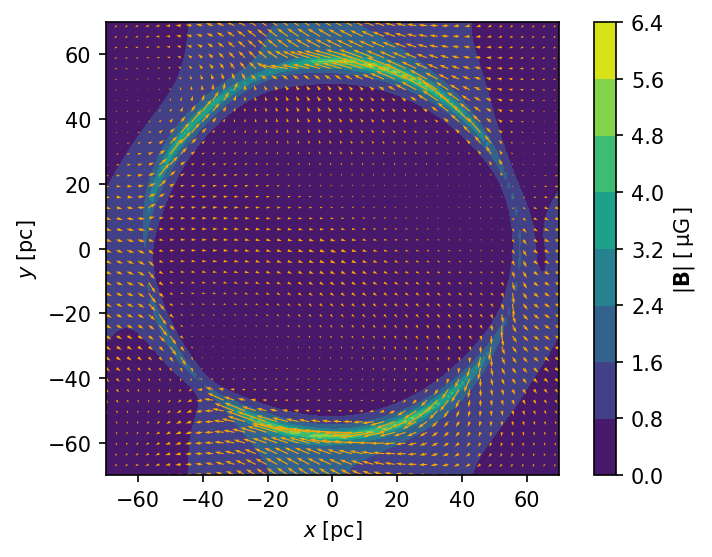

In [8]:
visu.plot_vector_xy(grid, [Bx, By, Bz]);

# Observables

Let us set up a cosmic ray density proportional to the magnetic field strength

../shell/visualization.py:32: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im_slice.value, **kwargs)


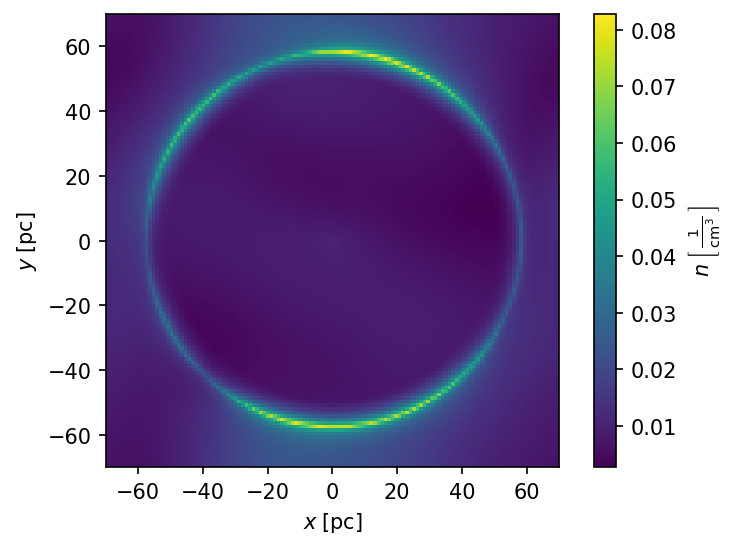

In [9]:
ncr = np.sqrt(Bx**2+By**2+Bz**2)
ncr /= ncr.max()
ncr *= 0.1*u.cm**-3
visu.plot_scalar_xy(grid, ncr);

In [26]:
lamb = 20*u.cm
lamb2 = 21*u.cm
I, U, Q = obs.compute_stokes_parameters(grid, lamb, Bx, By, Bz, ne, ncr)
I2, U2, Q2 = obs.compute_stokes_parameters(grid, lamb2, Bx, By, Bz, ne, ncr)

Psi = obs.compute_Psi(U, Q)
Psi2 = obs.compute_Psi(U2, Q2)
RM = obs.compute_RM(Psi, Psi2, lamb, lamb2).si

In [27]:
ncr.unit, I.unit, ne.unit

(Unit("1 / cm3"), Unit("pc uG2 / cm3"), Unit("1 / cm3"))

In [28]:
from importlib import reload
reload(hel)


# Radius of the remnant/box
Lz = (grid.box[2][1]-grid.box[2][0])/2

ncr_mean = np.mean(ncr, axis=2)
ne_mean = np.mean(ne, axis=2)

Hz, Jz = hel.average_helicity(RM=RM, I=I, PA=Psi,
                              wavelengths=[lamb,lamb2],
                              ne=ne, ncr=ncr, L=Lz,
                              x=grid.x[:,0,0], 
                              y=grid.y[0,:,0],
                              boundary_radius=2, 
                              output_current=True)



../shell/visualization.py:32: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im_slice.value, **kwargs)


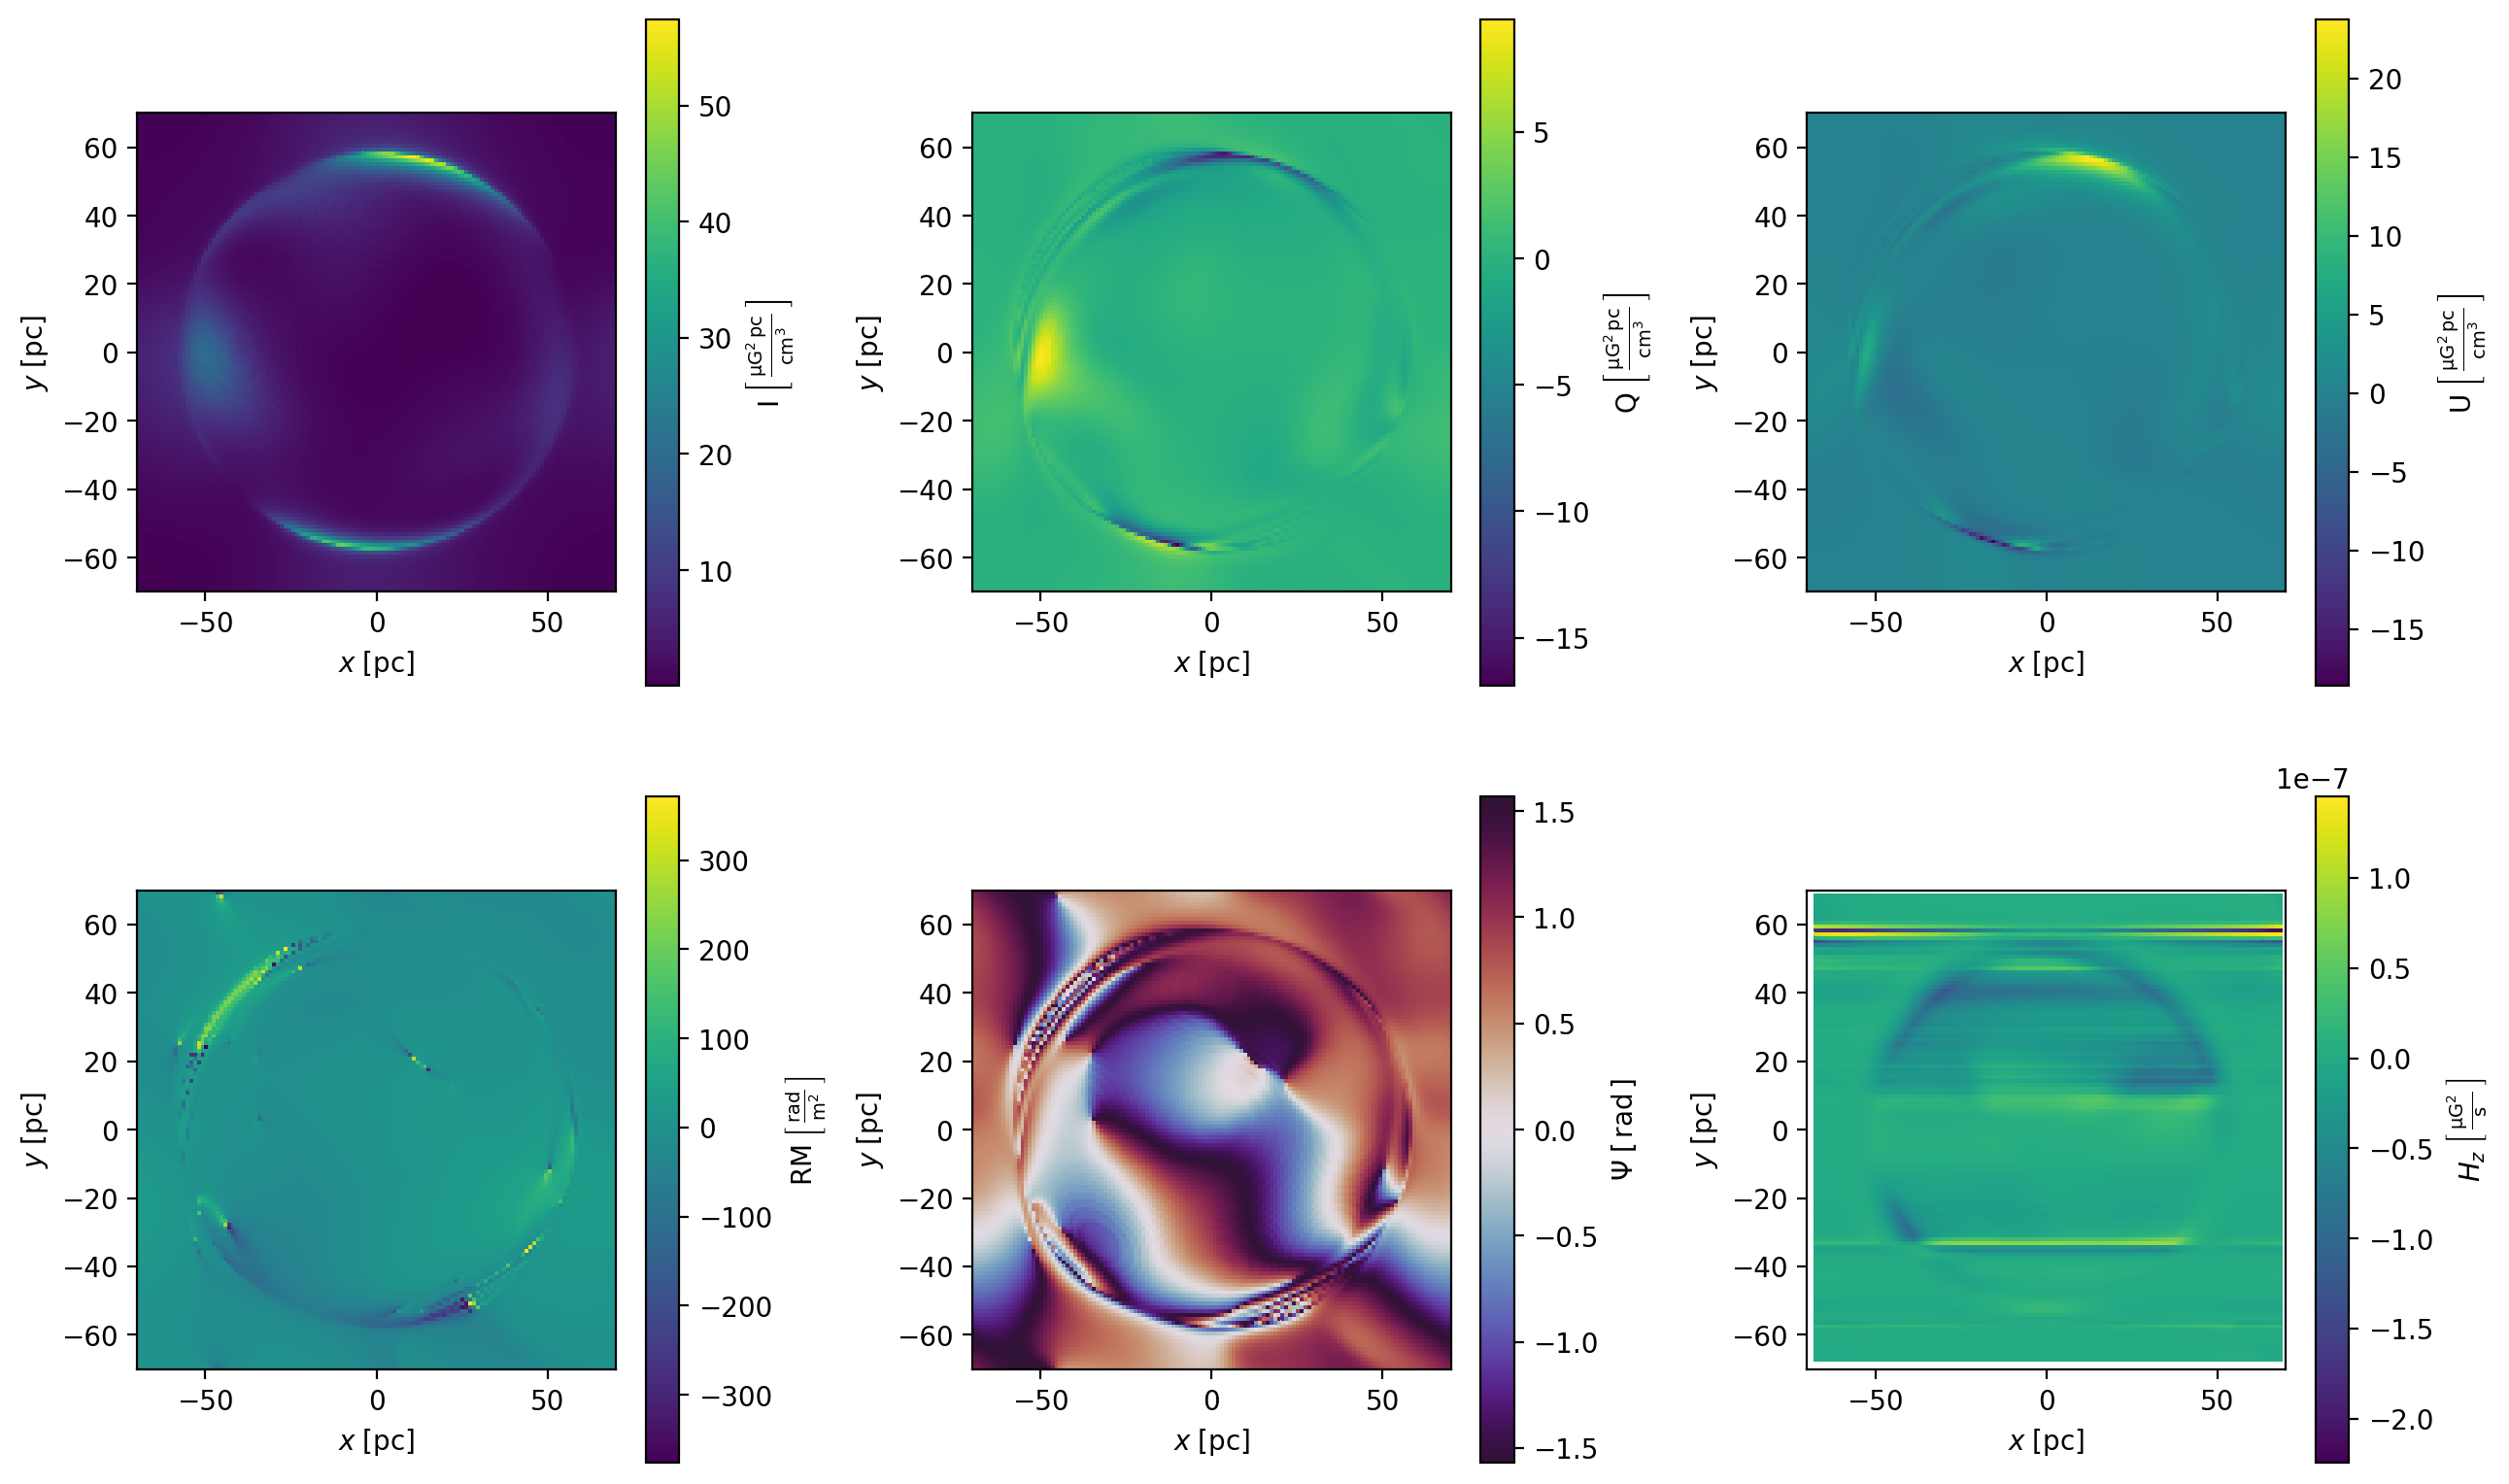

In [29]:
plt.figure(figsize=(13,8), dpi=200)
ax = plt.subplot(231)
visu.plot_scalar_xy(grid, I, ax=ax, name=r'\rm I')
ax = plt.subplot(232)
visu.plot_scalar_xy(grid, Q, ax=ax, name=r'\rm Q')
ax = plt.subplot(233)
visu.plot_scalar_xy(grid, U, ax=ax, name=r'\rm U')
ax = plt.subplot(234)
visu.plot_scalar_xy(grid, RM, ax=ax, name=r'\rm RM')
ax = plt.subplot(235)
visu.plot_scalar_xy(grid, Psi, ax=ax, name=r'\Psi')
ax = plt.subplot(236)
visu.plot_scalar_xy(grid, Hz, ax=ax, name=r'H_z')
plt.tight_layout()